In [40]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py

Importing modules

In [41]:
import re
import operator
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
import string

from bert import tokenization
from wordcloud import STOPWORDS
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

Loading in data

In [10]:
test_data = pd.read_csv('data/test_data.csv', dtype={'id': np.int16, 'target': np.int8})
train_data = pd.read_csv('data/train_data.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(train_data.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_data.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_data.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_data.memory_usage().sum() / 1024**2))

print(test_data.head())
print(train_data.head())

Training Set Shape = (35918, 2)
Training Set Memory Usage = 0.55 MB
Test Set Shape = (8980, 2)
Test Set Memory Usage = 0.14 MB
                                             content  label
0  Philippines doctor linked to New York attack p...      1
1  More Republicans expect Clinton, rather than T...      1
2  DEMOCRAT UNDERBELLY EXPOSED: Out-Of-Control Vi...      0
3  Those who boycott Syrian congress may be sidel...      1
4  Burundi opposition platform boycotts new round...      1
                                             content  label
0  Search ends for bodies in Mexico City after ea...      1
1  Former Catalan cabinet members appear before S...      1
2  ATTORNEY FOR STEINLE KILLER Calls Verdict ‘Vin...      0
3  Trump gains on Clinton, poll shows 'rigged' me...      1
4  Republican Trump says 70 percent of federal re...      1


Graphing meta features

In [4]:
# word_count
train_data['word_count'] = train_data['content'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['content'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['content'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['content'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['content'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['content'].apply(lambda x: len(str(x)))

# punctuation_count
train_data['punctuation_count'] = train_data['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_data['punctuation_count'] = test_data['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

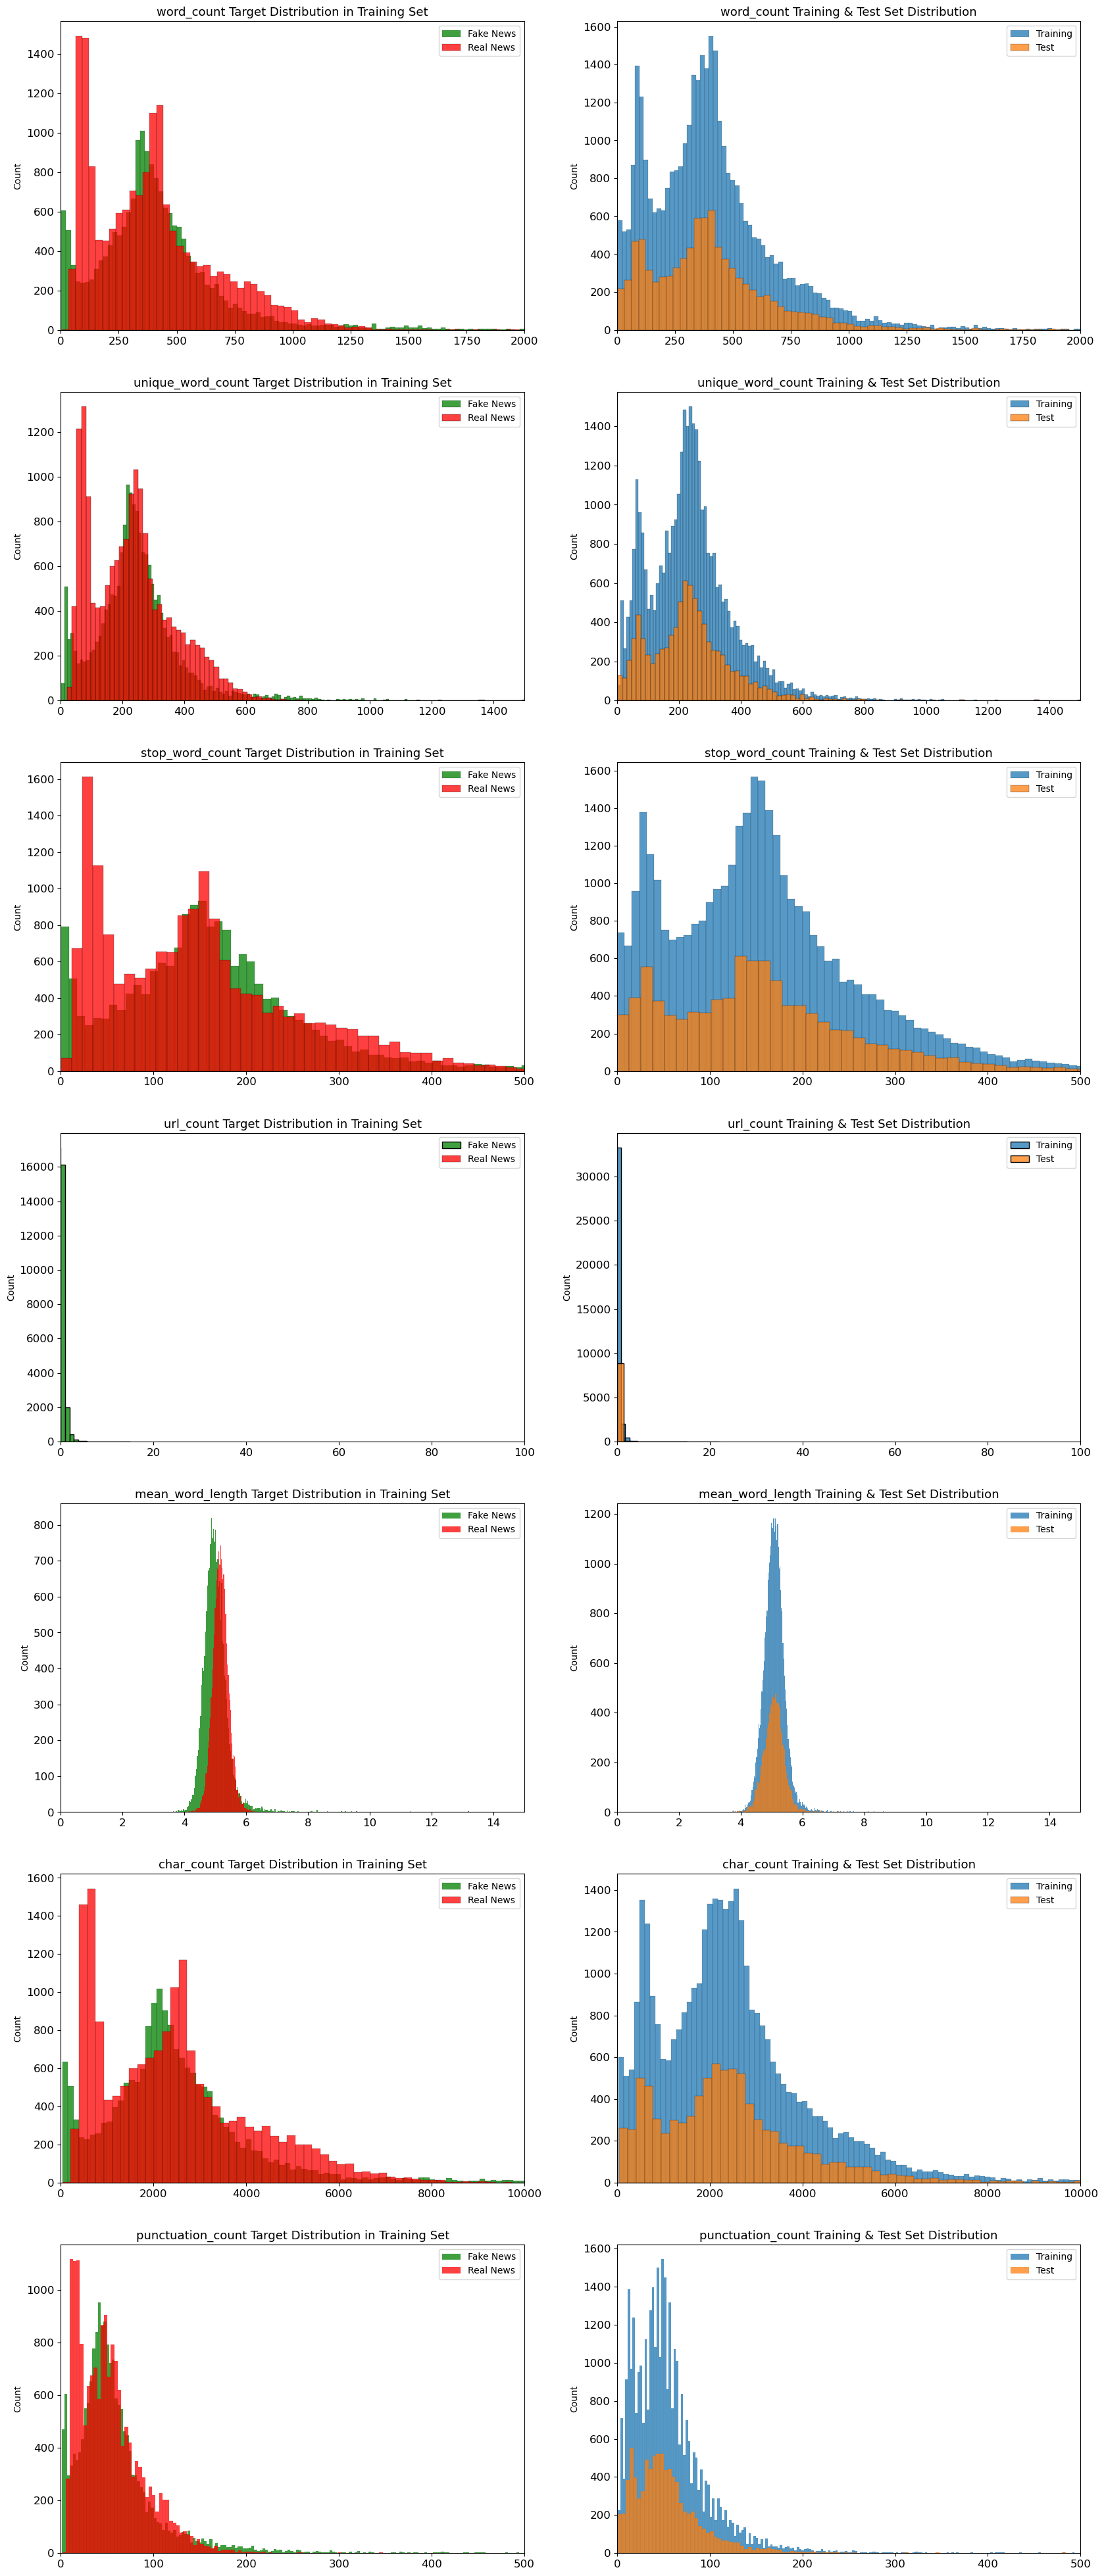

In [5]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count']
FAKE_OR_REAL_NEWS = train_data['label'] == 1

# Define max x-axis values for each feature to spread out the data
max_values = {
    'word_count': 2000,
    'unique_word_count': 1500,
    'stop_word_count': 500,
    'url_count': 100,
    'mean_word_length': 15,
    'char_count': 10000,
    'punctuation_count': 500
}

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_data.loc[~FAKE_OR_REAL_NEWS][feature], label='Fake News', ax=axes[i][0], color='green')
    sns.histplot(train_data.loc[FAKE_OR_REAL_NEWS][feature], label='Real News', ax=axes[i][0], color='red')

    sns.histplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.histplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].set_xlim(0, right=max_values[feature])
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

Target

In [6]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
real_news_unigrams = defaultdict(int)
fake_news_unigrams = defaultdict(int)

for tweet in train_data[FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet):
        real_news_unigrams[word] += 1

for tweet in train_data[~FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet):
        fake_news_unigrams[word] += 1

df_real_news_unigrams = pd.DataFrame(sorted(real_news_unigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_unigrams = pd.DataFrame(sorted(fake_news_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
real_news_bigrams = defaultdict(int)
fake_news_bigrams = defaultdict(int)

for tweet in train_data[FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet, n_gram=2):
        real_news_bigrams[word] += 1

for tweet in train_data[~FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet, n_gram=2):
        fake_news_bigrams[word] += 1

df_real_news_bigrams = pd.DataFrame(sorted(real_news_bigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_bigrams = pd.DataFrame(sorted(fake_news_bigrams.items(), key=lambda x: x[1])[::-1])

for tweet in train_data[~FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet, n_gram=2):
        fake_news_bigrams[word] += 1

df_real_news_bigrams = pd.DataFrame(sorted(real_news_bigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_bigrams = pd.DataFrame(sorted(fake_news_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
real_news_trigrams = defaultdict(int)
fake_news_trigrams = defaultdict(int)

for tweet in train_data[FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet, n_gram=3):
        real_news_trigrams[word] += 1

for tweet in train_data[~FAKE_OR_REAL_NEWS]['content']:
    for word in generate_ngrams(tweet, n_gram=3):
        fake_news_trigrams[word] += 1

df_real_news_trigrams = pd.DataFrame(sorted(real_news_trigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_trigrams = pd.DataFrame(sorted(fake_news_trigrams.items(), key=lambda x: x[1])[::-1])

Unigrams

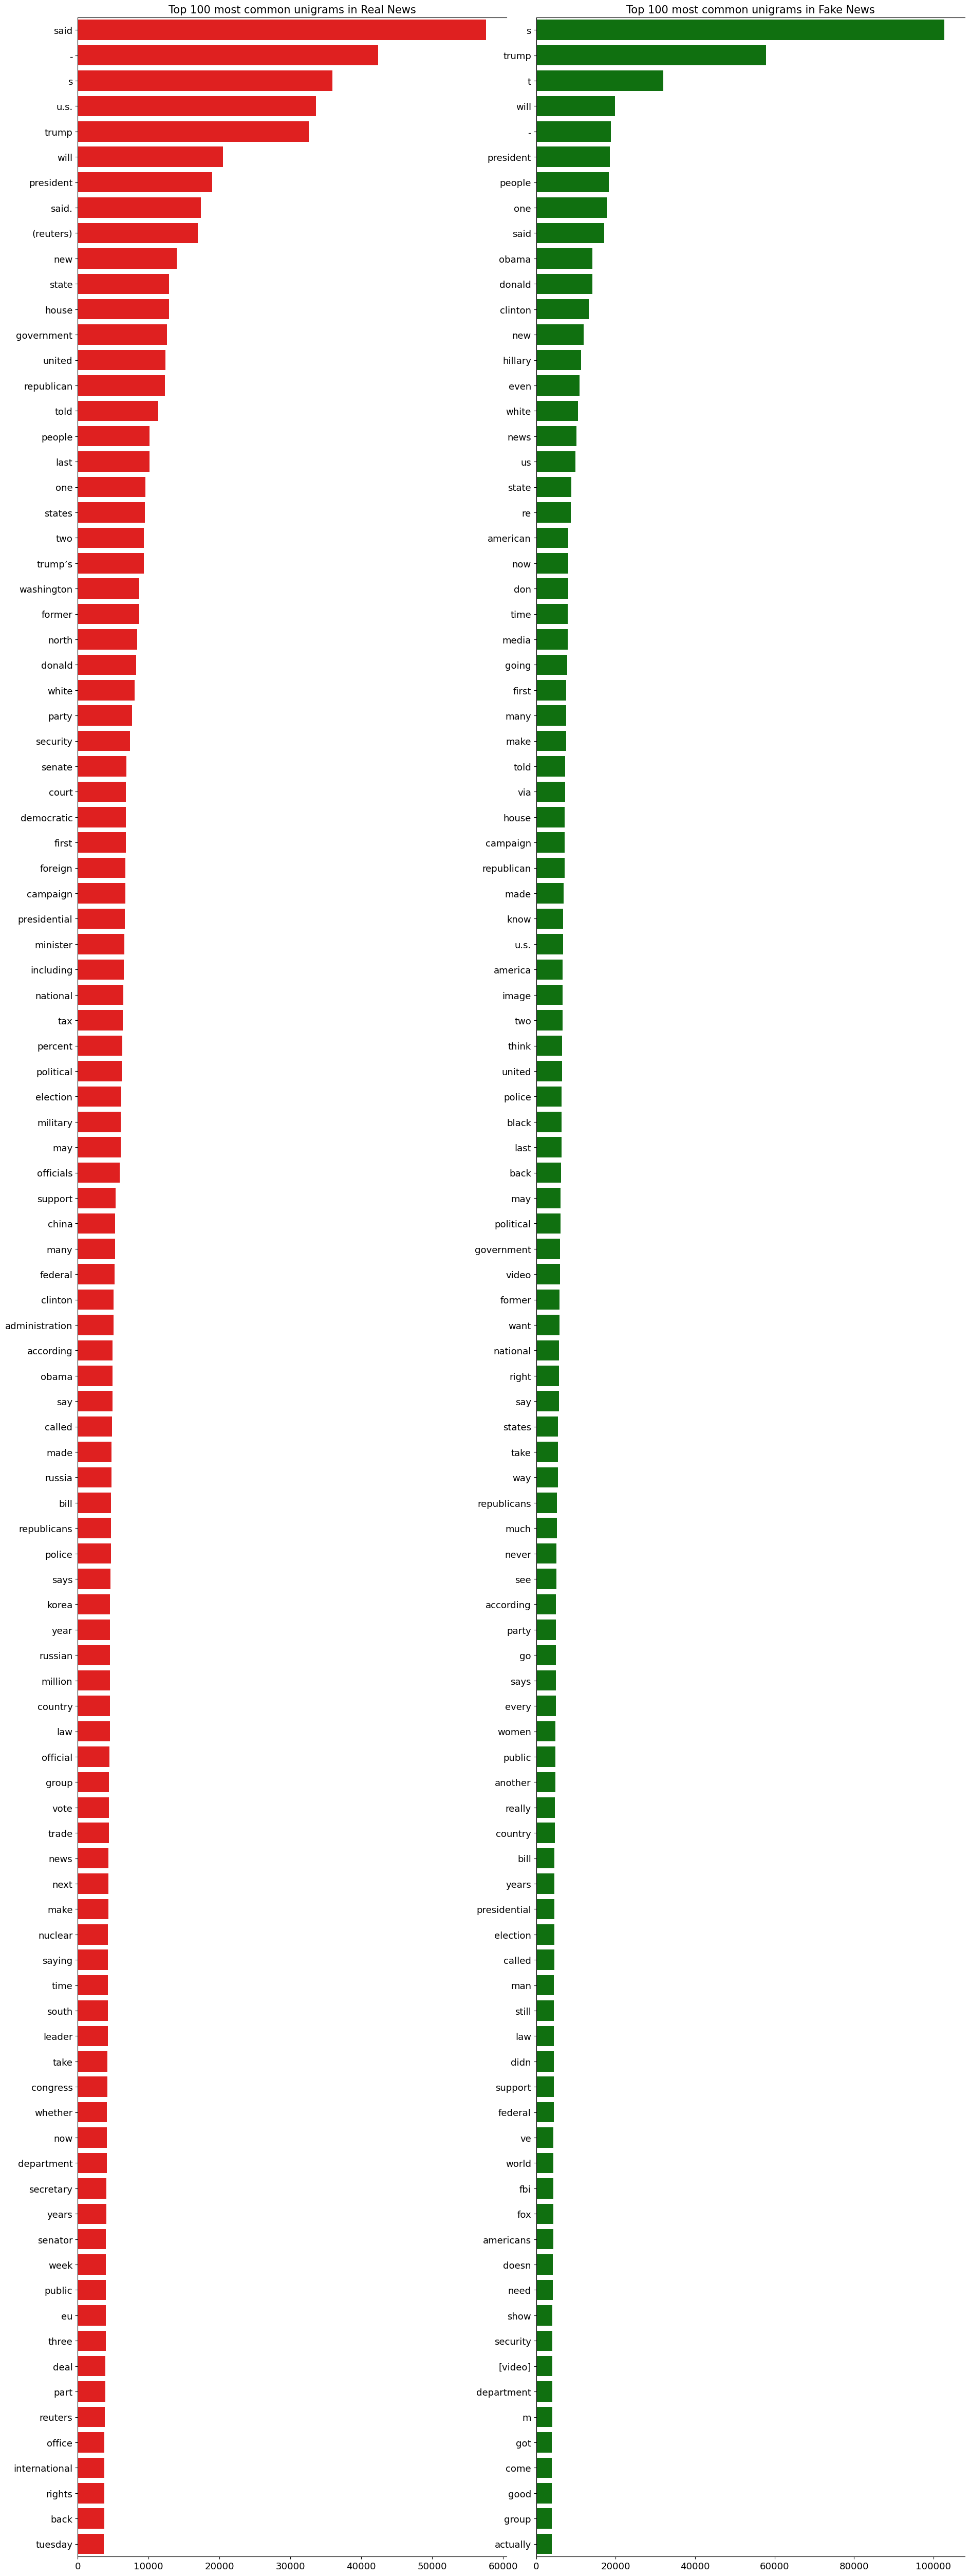

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_news_unigrams[0].values[:N], x=df_real_news_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_news_unigrams[0].values[:N], x=df_fake_news_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Real News', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Fake News', fontsize=15)

plt.show()

Bigrams

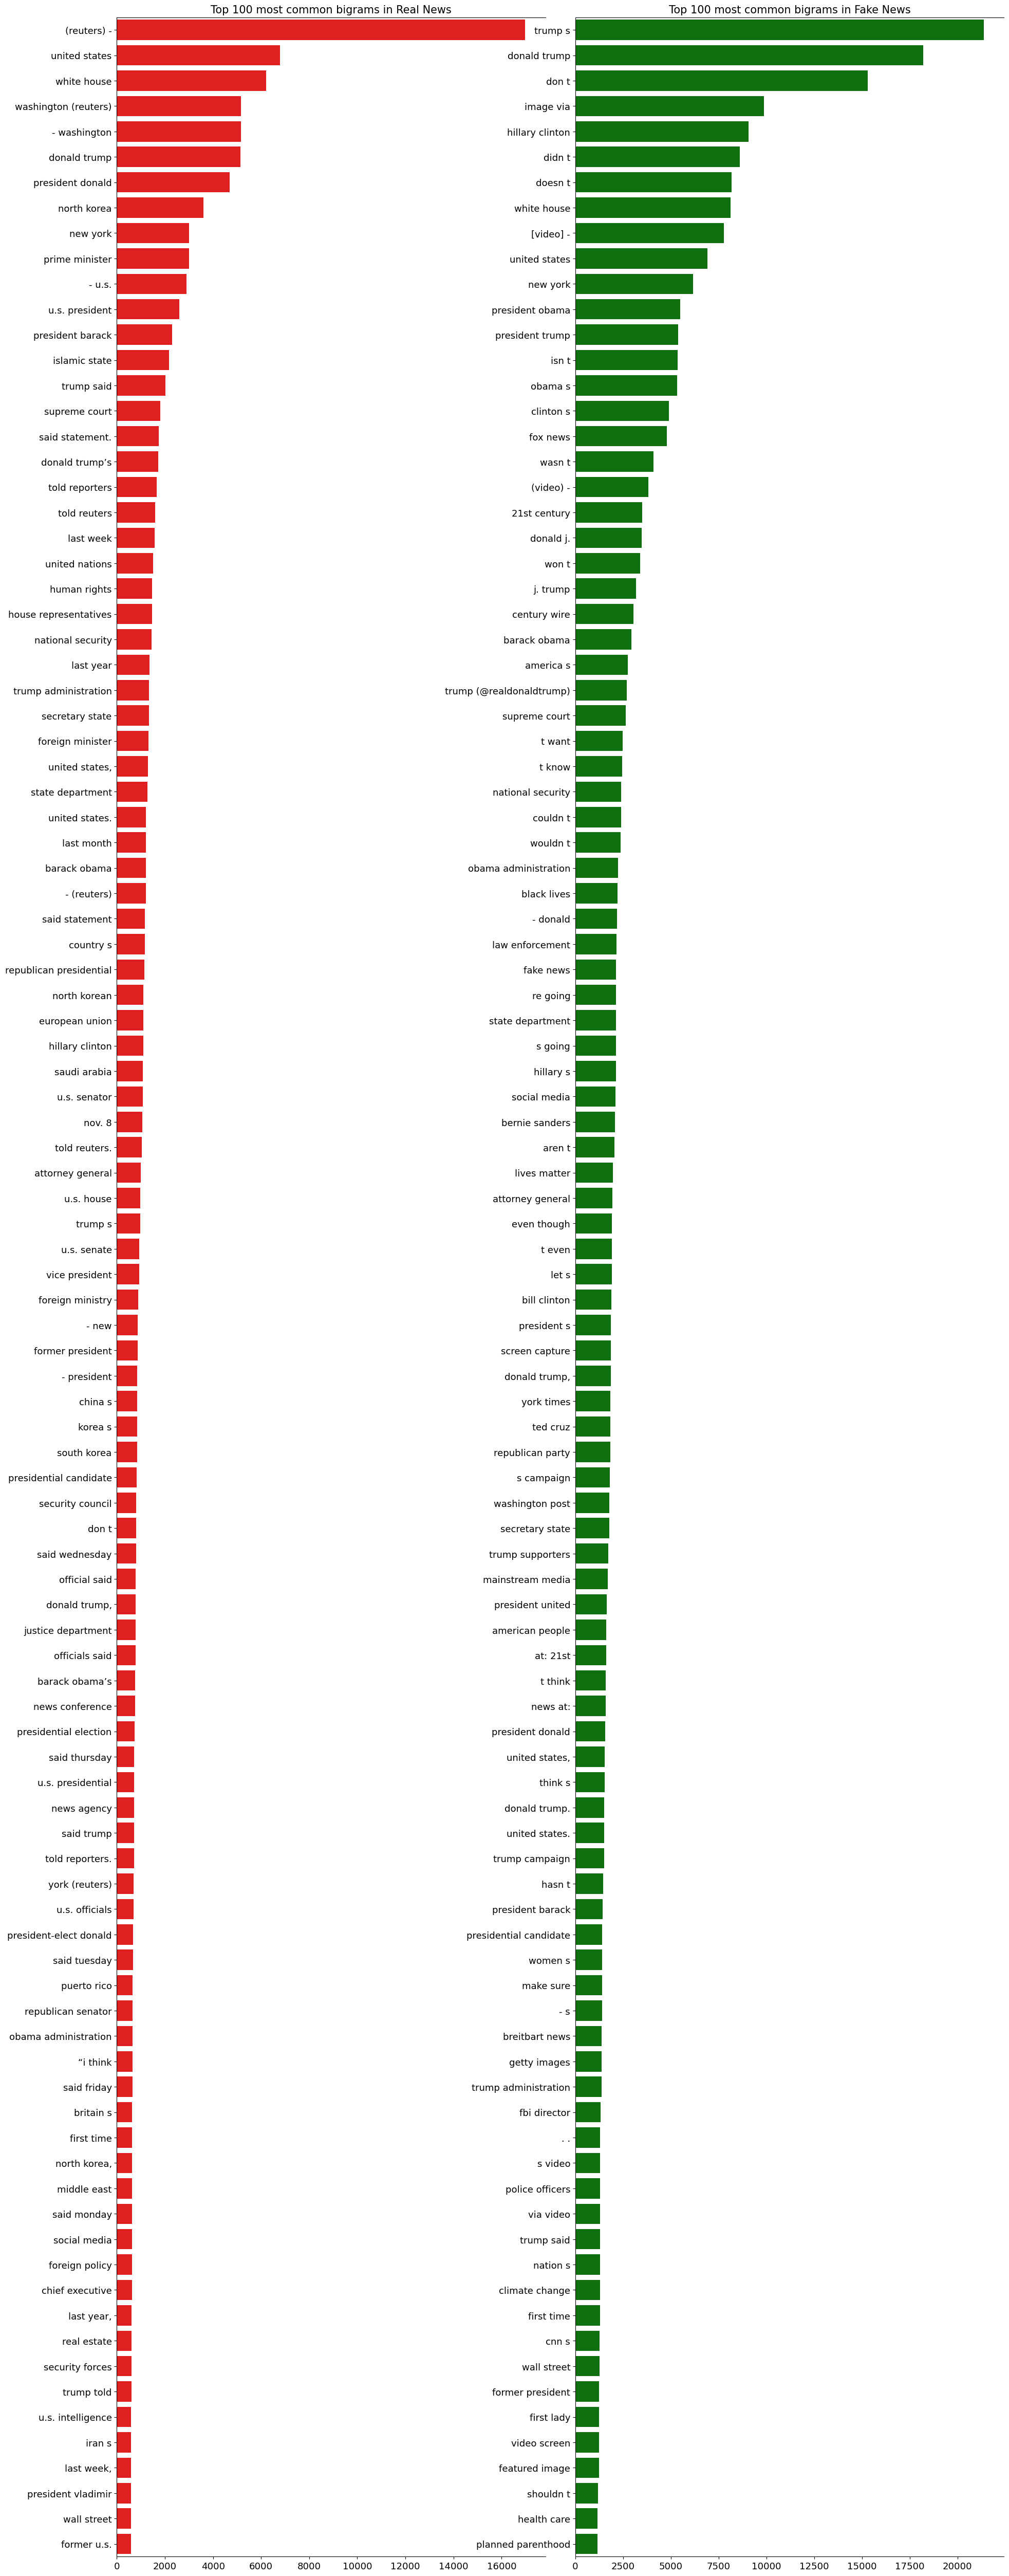

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_news_bigrams[0].values[:N], x=df_real_news_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_news_bigrams[0].values[:N], x=df_fake_news_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Real News', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Fake News', fontsize=15)

plt.show()

Trigrams

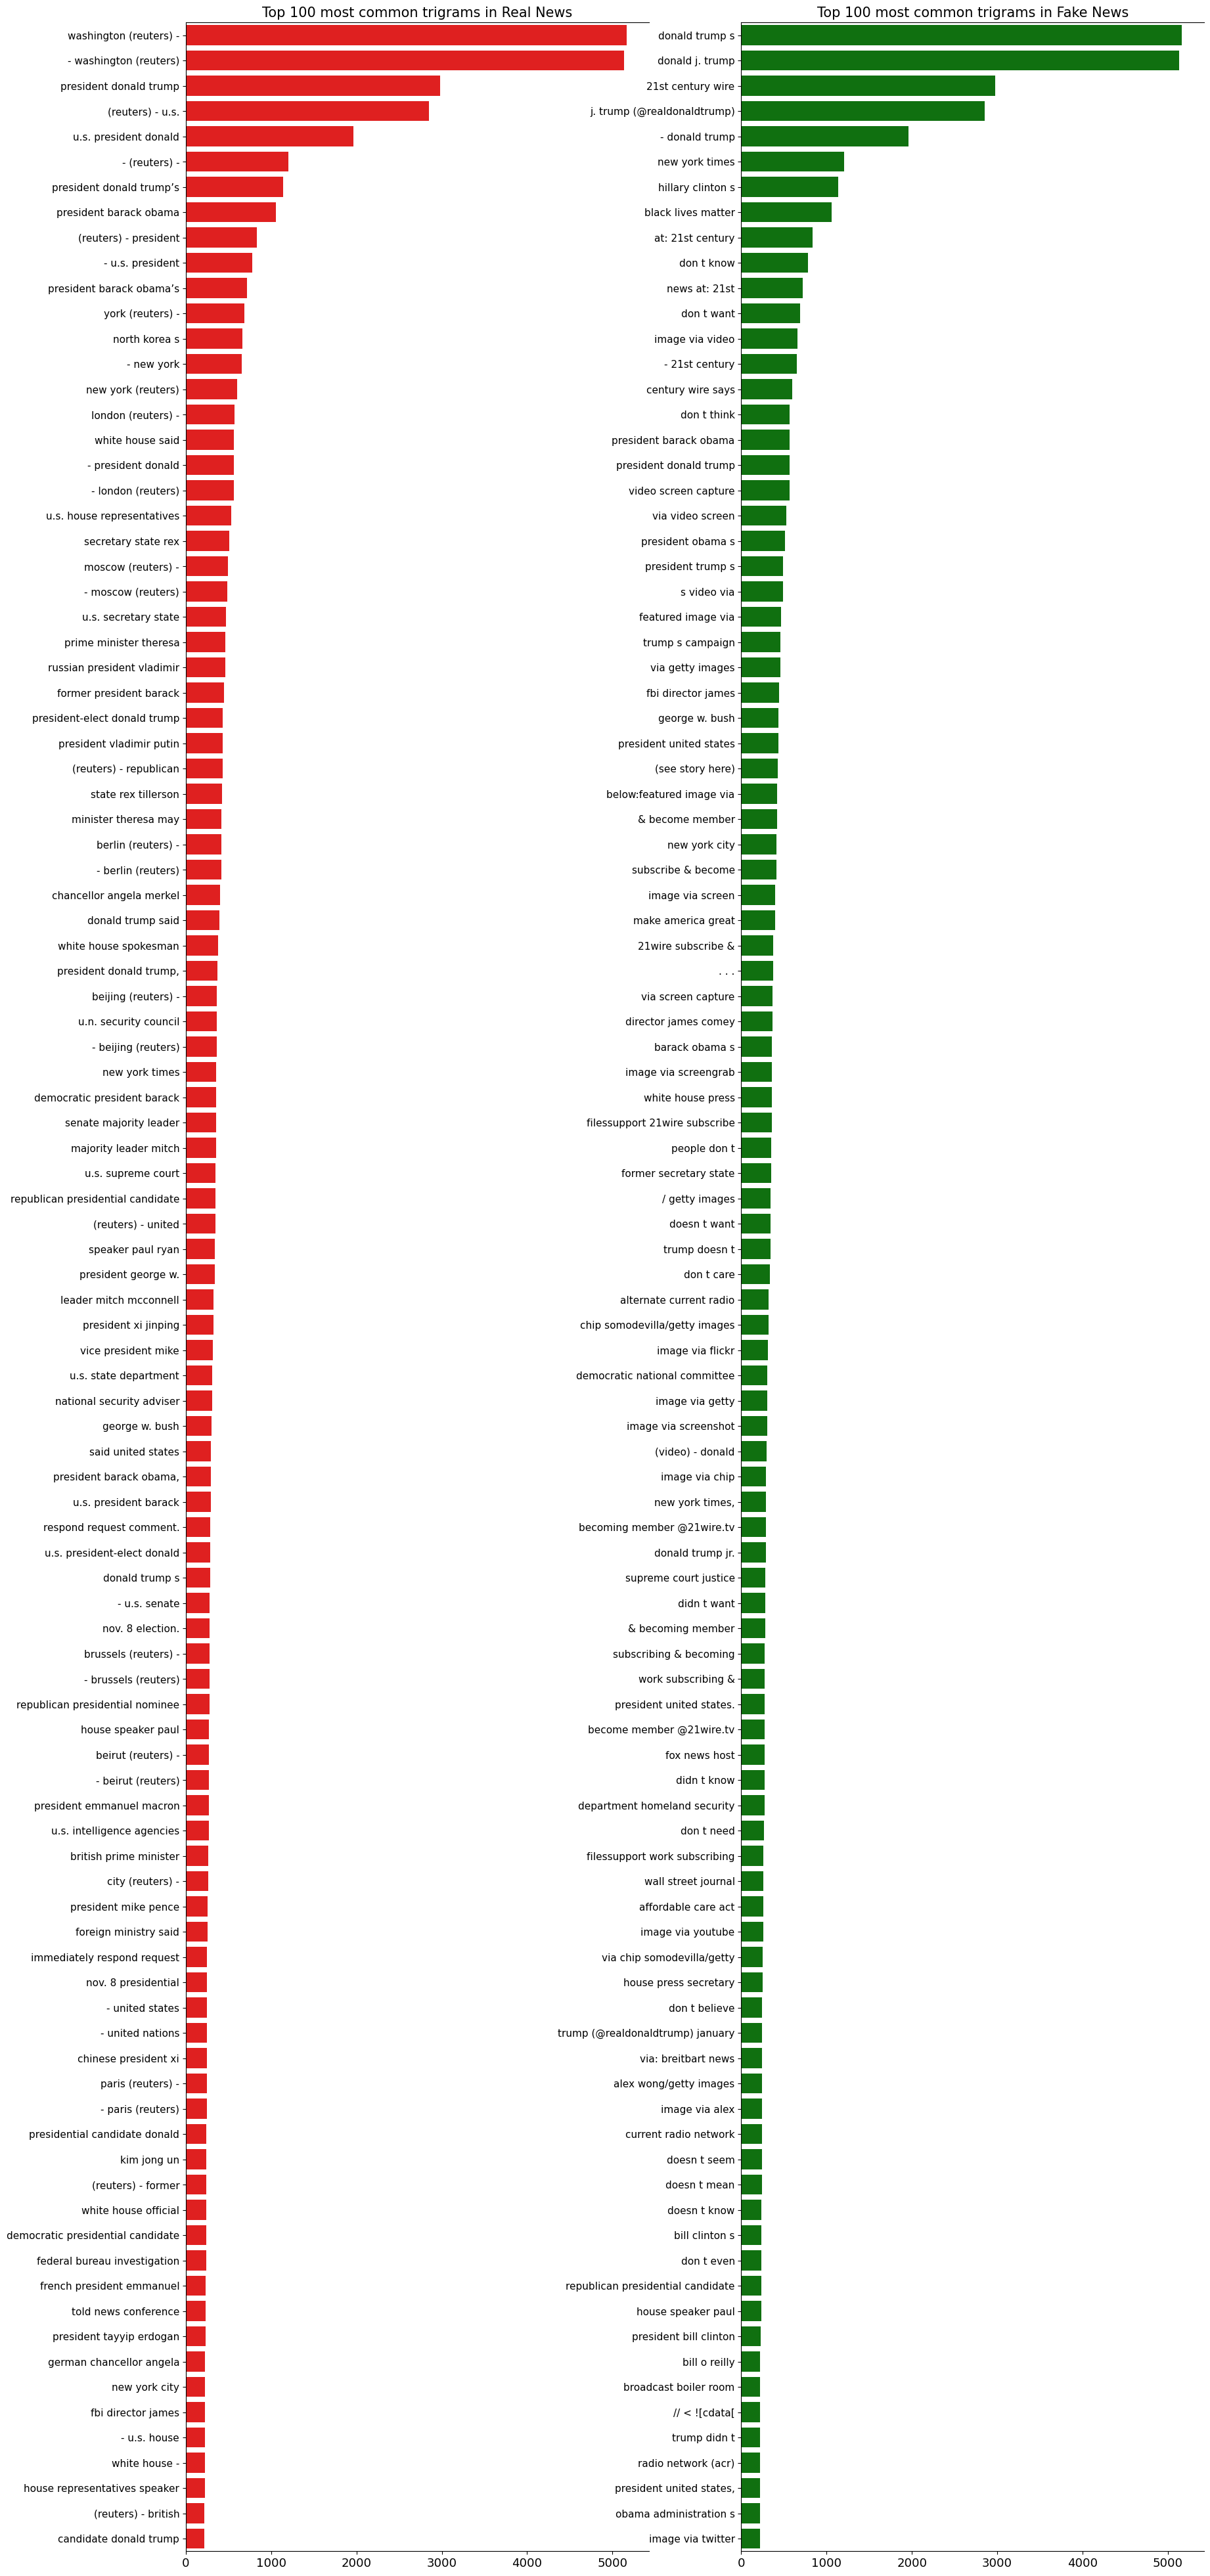

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_real_news_trigrams[0].values[:N], x=df_real_news_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_news_trigrams[0].values[:N], x=df_real_news_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Real News', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Fake News', fontsize=15)

plt.show()

Embeddings

In [10]:
glove_embeddings = np.load('pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

In [19]:
def build_vocab(X):
    
    news_text = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for news_text in news_text:
        for word in news_text:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train_data['content'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test_data['content'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train_data['content'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test_data['content'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 31.74% of vocabulary and 90.80% of text in Training Set
GloVe Embeddings cover 41.41% of vocabulary and 90.85% of text in Test Set
FastText Embeddings cover 36.19% of vocabulary and 92.19% of text in Training Set
FastText Embeddings cover 46.40% of vocabulary and 92.22% of text in Test Set


Text cleaning

In [20]:
def clean(news_text): 
    # Contractions
    news_text = re.sub(r"he's", "he is", news_text)
    news_text = re.sub(r"there's", "there is", news_text)
    news_text = re.sub(r"We're", "We are", news_text)
    news_text = re.sub(r"That's", "That is", news_text)
    news_text = re.sub(r"won't", "will not", news_text)
    news_text = re.sub(r"they're", "they are", news_text)
    news_text = re.sub(r"Can't", "Cannot", news_text)
    news_text = re.sub(r"wasn't", "was not", news_text)
    news_text = re.sub(r"don\x89Ûªt", "do not", news_text)
    news_text = re.sub(r"aren't", "are not", news_text)
    news_text = re.sub(r"isn't", "is not", news_text)
    news_text = re.sub(r"What's", "What is", news_text)
    news_text = re.sub(r"haven't", "have not", news_text)
    news_text = re.sub(r"hasn't", "has not", news_text)
    news_text = re.sub(r"There's", "There is", news_text)
    news_text = re.sub(r"He's", "He is", news_text)
    news_text = re.sub(r"It's", "It is", news_text)
    news_text = re.sub(r"You're", "You are", news_text)
    news_text = re.sub(r"I'M", "I am", news_text)
    news_text = re.sub(r"shouldn't", "should not", news_text)
    news_text = re.sub(r"wouldn't", "would not", news_text)
    news_text = re.sub(r"i'm", "I am", news_text)
    news_text = re.sub(r"I\x89Ûªm", "I am", news_text)
    news_text = re.sub(r"I'm", "I am", news_text)
    news_text = re.sub(r"Isn't", "is not", news_text)
    news_text = re.sub(r"Here's", "Here is", news_text)
    news_text = re.sub(r"you've", "you have", news_text)
    news_text = re.sub(r"you\x89Ûªve", "you have", news_text)
    news_text = re.sub(r"we're", "we are", news_text)
    news_text = re.sub(r"what's", "what is", news_text)
    news_text = re.sub(r"couldn't", "could not", news_text)
    news_text = re.sub(r"we've", "we have", news_text)
    news_text = re.sub(r"it\x89Ûªs", "it is", news_text)
    news_text = re.sub(r"doesn\x89Ûªt", "does not", news_text)
    news_text = re.sub(r"It\x89Ûªs", "It is", news_text)
    news_text = re.sub(r"Here\x89Ûªs", "Here is", news_text)
    news_text = re.sub(r"who's", "who is", news_text)
    news_text = re.sub(r"I\x89Ûªve", "I have", news_text)
    news_text = re.sub(r"y'all", "you all", news_text)
    news_text = re.sub(r"can\x89Ûªt", "cannot", news_text)
    news_text = re.sub(r"would've", "would have", news_text)
    news_text = re.sub(r"it'll", "it will", news_text)
    news_text = re.sub(r"we'll", "we will", news_text)
    news_text = re.sub(r"wouldn\x89Ûªt", "would not", news_text)
    news_text = re.sub(r"We've", "We have", news_text)
    news_text = re.sub(r"he'll", "he will", news_text)
    news_text = re.sub(r"Y'all", "You all", news_text)
    news_text = re.sub(r"Weren't", "Were not", news_text)
    news_text = re.sub(r"Didn't", "Did not", news_text)
    news_text = re.sub(r"they'll", "they will", news_text)
    news_text = re.sub(r"they'd", "they would", news_text)
    news_text = re.sub(r"DON'T", "DO NOT", news_text)
    news_text = re.sub(r"That\x89Ûªs", "That is", news_text)
    news_text = re.sub(r"they've", "they have", news_text)
    news_text = re.sub(r"i'd", "I would", news_text)
    news_text = re.sub(r"should've", "should have", news_text)
    news_text = re.sub(r"You\x89Ûªre", "You are", news_text)
    news_text = re.sub(r"where's", "where is", news_text)
    news_text = re.sub(r"Don\x89Ûªt", "Do not", news_text)
    news_text = re.sub(r"we'd", "we would", news_text)
    news_text = re.sub(r"i'll", "I will", news_text)
    news_text = re.sub(r"weren't", "were not", news_text)
    news_text = re.sub(r"They're", "They are", news_text)
    news_text = re.sub(r"Can\x89Ûªt", "Cannot", news_text)
    news_text = re.sub(r"you\x89Ûªll", "you will", news_text)
    news_text = re.sub(r"I\x89Ûªd", "I would", news_text)
    news_text = re.sub(r"let's", "let us", news_text)
    news_text = re.sub(r"it's", "it is", news_text)
    news_text = re.sub(r"can't", "cannot", news_text)
    news_text = re.sub(r"don't", "do not", news_text)
    news_text = re.sub(r"you're", "you are", news_text)
    news_text = re.sub(r"i've", "I have", news_text)
    news_text = re.sub(r"that's", "that is", news_text)
    news_text = re.sub(r"i'll", "I will", news_text)
    news_text = re.sub(r"doesn't", "does not", news_text)
    news_text = re.sub(r"i'd", "I would", news_text)
    news_text = re.sub(r"didn't", "did not", news_text)
    news_text = re.sub(r"ain't", "am not", news_text)
    news_text = re.sub(r"you'll", "you will", news_text)
    news_text = re.sub(r"I've", "I have", news_text)
    news_text = re.sub(r"Don't", "do not", news_text)
    news_text = re.sub(r"I'll", "I will", news_text)
    news_text = re.sub(r"I'd", "I would", news_text)
    news_text = re.sub(r"Let's", "Let us", news_text)
    news_text = re.sub(r"you'd", "You would", news_text)
    news_text = re.sub(r"It's", "It is", news_text)
    news_text = re.sub(r"Ain't", "am not", news_text)
    news_text = re.sub(r"Haven't", "Have not", news_text)
    news_text = re.sub(r"Could've", "Could have", news_text)
    news_text = re.sub(r"youve", "you have", news_text)  
    news_text = re.sub(r"donå«t", "do not", news_text) 
    news_text = re.sub(r"U.S", "United States", news_text)
    
    #cleaning
    news_text = re.sub(r"2017The", "2017 The", news_text)
    news_text = re.sub(r"2017Trump", "2017 Trump", news_text)
    news_text = re.sub(r"2017This", "2017 This", news_text)
    news_text = re.sub(r"2017Here", "2017 Here", news_text)
    news_text = re.sub(r"2017Donald", "2017 Donald", news_text)
    news_text = re.sub(r"2017It", "2017 It", news_text)
    news_text = re.sub(r"2016Featured", "2016 Featured", news_text)
    news_text = re.sub(r"2016And", "2016 And", news_text)
    news_text = re.sub(r"HillaryClinton", "Hillary Clinton", news_text)
            
    # Character entity references
    news_text = re.sub(r"&gt;", ">", news_text)
    news_text = re.sub(r"&lt;", "<", news_text)
    news_text = re.sub(r"&amp;", "&", news_text)
           
    # Urls
    news_text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", news_text)
    URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
    def normalize_urls(text):
        return URL_PATTERN.sub('', text)
    
    news_text = normalize_urls(news_text)
        
    # Words with punctuations and special characters
    punctuations = '`"”’‘“,@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        news_text = news_text.replace(p, f' {p} ')
        
    # ... and ..
    news_text = news_text.replace('...', ' ... ')
    if '...' not in news_text:
        news_text = news_text.replace('..', ' ... ')     
    return news_text

train_data['text_cleaned'] = train_data['content'].apply(lambda s : clean(s))
test_data['text_cleaned'] = test_data['content'].apply(lambda s : clean(s))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train_data['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test_data['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train_data['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test_data['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 76.38% of vocabulary and 99.51% of text in Training Set
GloVe Embeddings cover 85.33% of vocabulary and 99.49% of text in Test Set
FastText Embeddings cover 77.41% of vocabulary and 99.62% of text in Training Set
FastText Embeddings cover 86.18% of vocabulary and 99.61% of text in Test Set


Finding OOV words for GloVe and FastText for easier data cleaning

GLOVE OUT-OF-VOCABULARY WORDS

Top 50 OOV words in Training Set (GloVe):
            word  frequency
 realDonaldTrump       3632
          Brexit       2093
          21WIRE       1624
         SUnited        602
      Puigdemont        539
    FilesSUPPORT        469
     StatesCRIBE        384
       StatesELS        308
        BRUnited        308
          tmsnrt        276
         Finicum        272
   StatesCRIBING        207
   Veselnitskaya        203
     seanhannity        195
          Zarrab        190
           Daesh        183
BlackLivesMatter        165
         RUnited        161
          Lahren        160
       Trumpcare        158
            CNRP        153
       Cernovich        150
         2017And        150
          Ossoff        148
           jssdk        146
          Cliven        143
    2017Featured        143
          2017In        127
   foxandfriends        127
         Zaghari        120
          Strzok        119
           2017I        119
   

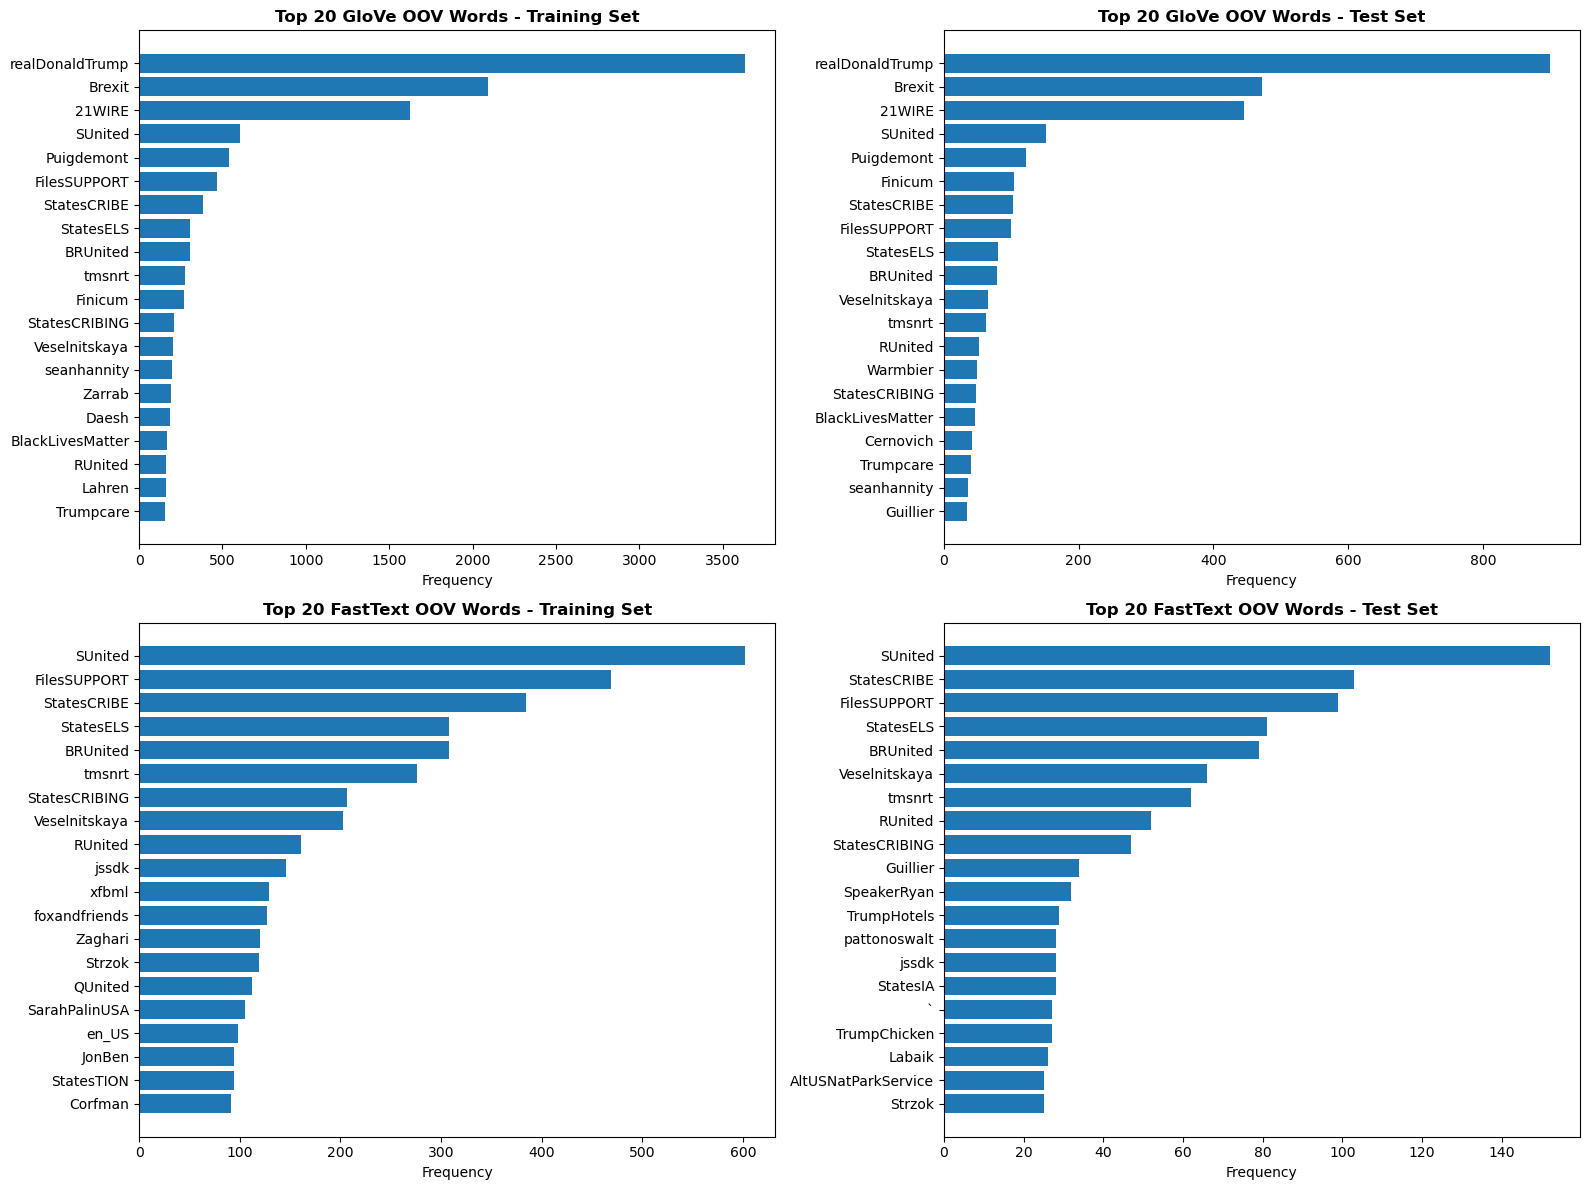

In [21]:
# Display Out-of-Vocabulary Words for GloVe and FastText

# GloVe OOV Analysis
print("=" * 80)
print("GLOVE OUT-OF-VOCABULARY WORDS")
print("=" * 80)

df_glove_train_oov = pd.DataFrame(train_glove_oov[:50], columns=['word', 'frequency'])
df_glove_test_oov = pd.DataFrame(test_glove_oov[:50], columns=['word', 'frequency'])

print("\nTop 50 OOV words in Training Set (GloVe):")
print(df_glove_train_oov.to_string(index=False))

print("\n\nTop 50 OOV words in Test Set (GloVe):")
print(df_glove_test_oov.to_string(index=False))

# FastText OOV Analysis
print("\n" + "=" * 80)
print("FASTTEXT OUT-OF-VOCABULARY WORDS")
print("=" * 80)

df_fasttext_train_oov = pd.DataFrame(train_fasttext_oov[:50], columns=['word', 'frequency'])
df_fasttext_test_oov = pd.DataFrame(test_fasttext_oov[:50], columns=['word', 'frequency'])

print("\nTop 50 OOV words in Training Set (FastText):")
print(df_fasttext_train_oov.to_string(index=False))

print("\n\nTop 50 OOV words in Test Set (FastText):")
print(df_fasttext_test_oov.to_string(index=False))

# Visualization of OOV words
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# GloVe Training
axes[0, 0].barh(range(min(20, len(df_glove_train_oov))), df_glove_train_oov['frequency'].head(20).values)
axes[0, 0].set_yticks(range(min(20, len(df_glove_train_oov))))
axes[0, 0].set_yticklabels(df_glove_train_oov['word'].head(20).values)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Top 20 GloVe OOV Words - Training Set', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()

# GloVe Test
axes[0, 1].barh(range(min(20, len(df_glove_test_oov))), df_glove_test_oov['frequency'].head(20).values)
axes[0, 1].set_yticks(range(min(20, len(df_glove_test_oov))))
axes[0, 1].set_yticklabels(df_glove_test_oov['word'].head(20).values)
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Top 20 GloVe OOV Words - Test Set', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()

# FastText Training
axes[1, 0].barh(range(min(20, len(df_fasttext_train_oov))), df_fasttext_train_oov['frequency'].head(20).values)
axes[1, 0].set_yticks(range(min(20, len(df_fasttext_train_oov))))
axes[1, 0].set_yticklabels(df_fasttext_train_oov['word'].head(20).values)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 20 FastText OOV Words - Training Set', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()

# FastText Test
axes[1, 1].barh(range(min(20, len(df_fasttext_test_oov))), df_fasttext_test_oov['frequency'].head(20).values)
axes[1, 1].set_yticks(range(min(20, len(df_fasttext_test_oov))))
axes[1, 1].set_yticklabels(df_fasttext_test_oov['word'].head(20).values)
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_title('Top 20 FastText OOV Words - Test Set', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


Cross validation

In [22]:
K = 2
kf = KFold(n_splits=K, random_state=SEED, shuffle=True)

REALNEWS = train_data['label'] == 1
print('Whole Training Set Shape = {}'.format(train_data.shape))
print('Whole Training Set Target Rate (Real News) {}/{} (Fake News)'.format(train_data[REALNEWS]['label'].count(), train_data[~REALNEWS]['label'].count()))

for fold, (trn_idx, val_idx) in enumerate(kf.split(train_data['text_cleaned']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_data.loc[trn_idx, 'text_cleaned'].shape, train_data.loc[val_idx, 'text_cleaned'].shape))

Whole Training Set Shape = (35918, 10)
Whole Training Set Target Rate (Real News) 17133/18785 (Fake News)

Fold 1 Training Set Shape = (17959,) - Validation Set Shape = (17959,)

Fold 2 Training Set Shape = (17959,) - Validation Set Shape = (17959,)


Metrics

In [43]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

BERT Layer

In [42]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

Architecture

In [64]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

try:
    from transformers import AutoTokenizer, AutoModel
except ImportError:
    print("Installing transformers library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'transformers'])
    from transformers import AutoTokenizer, AutoModel


class BertNewsDetector(nn.Module):
    """PyTorch BERT-based classifier for fake news detection."""
    
    def __init__(self, bert_model, dropout=0.1):
        super(BertNewsDetector, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)  # BERT hidden size is 768
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Forward pass through the model.
        Args:
            input_ids: Token IDs tensor
            attention_mask: Attention mask tensor
            token_type_ids: Token type IDs tensor
        Returns:
            Binary classification logits
        """
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, 
                               attention_mask=attention_mask, 
                               token_type_ids=token_type_ids)
        
        # Use [CLS] token representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        
        return logits


class FakeNewsDetector:
    """
    PyTorch-based Fake News Detector using BERT and k-fold cross-validation.
    Optimized for faster training by freezing BERT weights.
    """
    
    def __init__(self, max_seq_length=128, lr=0.001, epochs=5, batch_size=16, 
                 bert_model_name='bert-base-uncased', device=None):
        
        self.max_seq_length = max_seq_length
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.bert_model_name = bert_model_name
        
        # Set device (GPU if available, else CPU)
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        
        print(f"Using device: {self.device}")
        print(f"Loading BERT model: {bert_model_name}...")
        
        # Load tokenizer and BERT model once (shared across all folds)
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        self.bert_model = AutoModel.from_pretrained(bert_model_name).to(self.device)
        self.bert_model.eval()  # Set to eval mode since we're freezing weights
        
        print("BERT model loaded successfully!")
        
        self.models = []
        self.scores = {}
    
    def encode(self, texts):
        """
        Encode texts using BERT tokenizer.
        Args:
            texts: List of text strings
        Returns:
            Tuple of (input_ids, attention_masks, token_type_ids) as numpy arrays
        """
        all_input_ids = []
        all_attention_masks = []
        all_token_type_ids = []
        
        for text in texts:
            # Tokenize
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_seq_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True
            )
            
            all_input_ids.append(encoded['input_ids'])
            all_attention_masks.append(encoded['attention_mask'])
            all_token_type_ids.append(encoded['token_type_ids'])
        
        return (np.array(all_input_ids), 
                np.array(all_attention_masks), 
                np.array(all_token_type_ids))
    
    def train(self, X):
        """
        Train the model using k-fold cross-validation.
        Args:
            X: DataFrame with 'text_cleaned' and 'label' columns
        """
        
        for fold, (trn_idx, val_idx) in enumerate(kf.split(X['text_cleaned'])):
            
            print(f'\n{"="*60}')
            print(f'Fold {fold + 1}/{K}')
            print(f'{"="*60}\n')
            
            # Encode training and validation data
            print("Encoding training data...")
            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower().values)
            y_trn = X.loc[trn_idx, 'label'].values.astype(np.float32)
            
            print("Encoding validation data...")
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower().values)
            y_val = X.loc[val_idx, 'label'].values.astype(np.float32)
            
            # Create PyTorch datasets and dataloaders
            train_dataset = TensorDataset(
                torch.tensor(X_trn_encoded[0], dtype=torch.long),
                torch.tensor(X_trn_encoded[1], dtype=torch.long),
                torch.tensor(X_trn_encoded[2], dtype=torch.long),
                torch.tensor(y_trn, dtype=torch.float32).reshape(-1, 1)
            )
            
            val_dataset = TensorDataset(
                torch.tensor(X_val_encoded[0], dtype=torch.long),
                torch.tensor(X_val_encoded[1], dtype=torch.long),
                torch.tensor(X_val_encoded[2], dtype=torch.long),
                torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
            )
            
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
            
            # Build and train model
            model = BertNewsDetector(self.bert_model).to(self.device)
            optimizer = Adam(model.classifier.parameters(), lr=self.lr)
            loss_fn = nn.BCEWithLogitsLoss()
            
            # Training loop
            train_metrics = {
                'precision': [],
                'recall': [],
                'f1': []
            }
            val_metrics = {
                'precision': [],
                'recall': [],
                'f1': []
            }
            
            for epoch in range(self.epochs):
                # Training phase
                model.train()
                train_preds = []
                train_labels = []
                total_loss = 0
                
                for batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels in train_loader:
                    batch_input_ids = batch_input_ids.to(self.device)
                    batch_attention_mask = batch_attention_mask.to(self.device)
                    batch_token_type_ids = batch_token_type_ids.to(self.device)
                    batch_labels = batch_labels.to(self.device)
                    
                    # Forward pass
                    logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids)
                    loss = loss_fn(logits, batch_labels)
                    
                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    
                    # Store predictions
                    train_preds.extend((torch.sigmoid(logits) > 0.5).cpu().detach().numpy().flatten())
                    train_labels.extend(batch_labels.cpu().detach().numpy().flatten())
                
                # Calculate training metrics
                train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
                train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
                train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)
                
                train_metrics['precision'].append(train_precision)
                train_metrics['recall'].append(train_recall)
                train_metrics['f1'].append(train_f1)
                
                # Validation phase
                model.eval()
                val_preds = []
                val_labels = []
                
                with torch.no_grad():
                    for batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels in val_loader:
                        batch_input_ids = batch_input_ids.to(self.device)
                        batch_attention_mask = batch_attention_mask.to(self.device)
                        batch_token_type_ids = batch_token_type_ids.to(self.device)
                        batch_labels = batch_labels.to(self.device)
                        
                        logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids)
                        
                        val_preds.extend((torch.sigmoid(logits) > 0.5).cpu().detach().numpy().flatten())
                        val_labels.extend(batch_labels.cpu().detach().numpy().flatten())
                
                # Calculate validation metrics
                val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
                val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
                val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
                
                val_metrics['precision'].append(val_precision)
                val_metrics['recall'].append(val_recall)
                val_metrics['f1'].append(val_f1)
                
                print(f'Epoch {epoch + 1}/{self.epochs} - Loss: {total_loss/len(train_loader):.4f}')
                print(f'  Train - Precision: {train_precision:.6f}, Recall: {train_recall:.6f}, F1: {train_f1:.6f}')
                print(f'  Val   - Precision: {val_precision:.6f}, Recall: {val_recall:.6f}, F1: {val_f1:.6f}')
            
            # Store model and scores
            self.models.append(model)
            self.scores[fold] = {
                'train': train_metrics,
                'validation': val_metrics
            }
    
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

    # def plot_learning_curve(self):
    #     """Plot learning curves for all folds."""
    #     fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
        
    #     for i in range(1,2):
    #         # Validation metrics
    #         sns.lineplot(x=np.arange(1, self.epochs + 1), 
    #                     y=self.scores[i]['validation']['precision'], 
    #                     ax=axes[i][0], label='val_precision')
    #         sns.lineplot(x=np.arange(1, self.epochs + 1), 
    #                     y=self.scores[i]['validation']['recall'], 
    #                     ax=axes[i][0], label='val_recall')
    #         sns.lineplot(x=np.arange(1, self.epochs + 1), 
    #                     y=self.scores[i]['validation']['f1'], 
    #                     ax=axes[i][0], label='val_f1')
            
    #         axes[i][0].legend()
    #         axes[i][0].set_title(f'Fold {i} Validation Metrics', fontsize=14)
    #         axes[i][0].set_xlabel('Epoch', fontsize=12)
    #         axes[i][0].set_ylabel('Score', fontsize=12)
            
    #         # Train vs Val F1
    #         sns.lineplot(x=np.arange(1, self.epochs + 1), 
    #                     y=self.scores[i]['train']['f1'], 
    #                     ax=axes[i][1], label='train_f1')
    #         sns.lineplot(x=np.arange(1, self.epochs + 1), 
    #                     y=self.scores[i]['validation']['f1'], 
    #                     ax=axes[i][1], label='val_f1')
            
    #         axes[i][1].legend()
    #         axes[i][1].set_title(f'Fold {i} Train/Validation F1', fontsize=14)
    #         axes[i][1].set_xlabel('Epoch', fontsize=12)
    #         axes[i][1].set_ylabel('F1 Score', fontsize=12)
        
    #     plt.tight_layout()
    #     plt.show()
    
    # def predict(self, X):
    #     """
    #     Make predictions on new data using ensemble of trained models.
    #     Args:
    #         X: DataFrame with 'text_cleaned' column
    #     Returns:
    #         Prediction probabilities
    #     """
    #     X_test_encoded = self.encode(X['text_cleaned'].str.lower().values)
        
    #     test_dataset = TensorDataset(
    #         torch.tensor(X_test_encoded[0], dtype=torch.long),
    #         torch.tensor(X_test_encoded[1], dtype=torch.long),
    #         torch.tensor(X_test_encoded[2], dtype=torch.long)
    #     )
        
    #     test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        
    #     all_predictions = []
        
    #     for model in self.models:
    #         model.eval()
    #         fold_predictions = []
            
    #         with torch.no_grad():
    #             for batch_input_ids, batch_attention_mask, batch_token_type_ids in test_loader:
    #                 batch_input_ids = batch_input_ids.to(self.device)
    #                 batch_attention_mask = batch_attention_mask.to(self.device)
    #                 batch_token_type_ids = batch_token_type_ids.to(self.device)
                    
    #                 logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids)
    #                 probs = torch.sigmoid(logits).cpu().detach().numpy()
    #                 fold_predictions.extend(probs)
            
    #         all_predictions.append(np.array(fold_predictions))
        
    #     # Ensemble: average predictions across all models
    #     y_pred = np.mean(all_predictions, axis=0)
        
    #     return y_pred


Training, Evaluation, Prediction

In [56]:
clf = FakeNewsDetector(max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

clf.train(train_data)


Using device: cpu
Loading BERT model: bert-base-uncased...
BERT model loaded successfully!

Fold 1/2

Encoding training data...
Encoding validation data...
Epoch 1/10 - Loss: 0.4903
  Train - Precision: 0.856216, Recall: 0.841672, F1: 0.843040
  Val   - Precision: 0.919569, Recall: 0.919437, F1: 0.919501
Epoch 2/10 - Loss: 0.3096
  Train - Precision: 0.912533, Recall: 0.910112, F1: 0.910861
  Val   - Precision: 0.927105, Recall: 0.927651, F1: 0.927322
Epoch 3/10 - Loss: 0.2492
  Train - Precision: 0.920794, Recall: 0.919727, F1: 0.920136
  Val   - Precision: 0.933926, Recall: 0.934032, F1: 0.933978
Epoch 4/10 - Loss: 0.2186
  Train - Precision: 0.928033, Recall: 0.926998, F1: 0.927400
  Val   - Precision: 0.936711, Recall: 0.937181, F1: 0.936908
Epoch 5/10 - Loss: 0.1994
  Train - Precision: 0.932266, Recall: 0.931624, F1: 0.931895
  Val   - Precision: 0.940590, Recall: 0.941192, F1: 0.940824
Epoch 6/10 - Loss: 0.1848
  Train - Precision: 0.936814, Recall: 0.936324, F1: 0.936538
  Val 

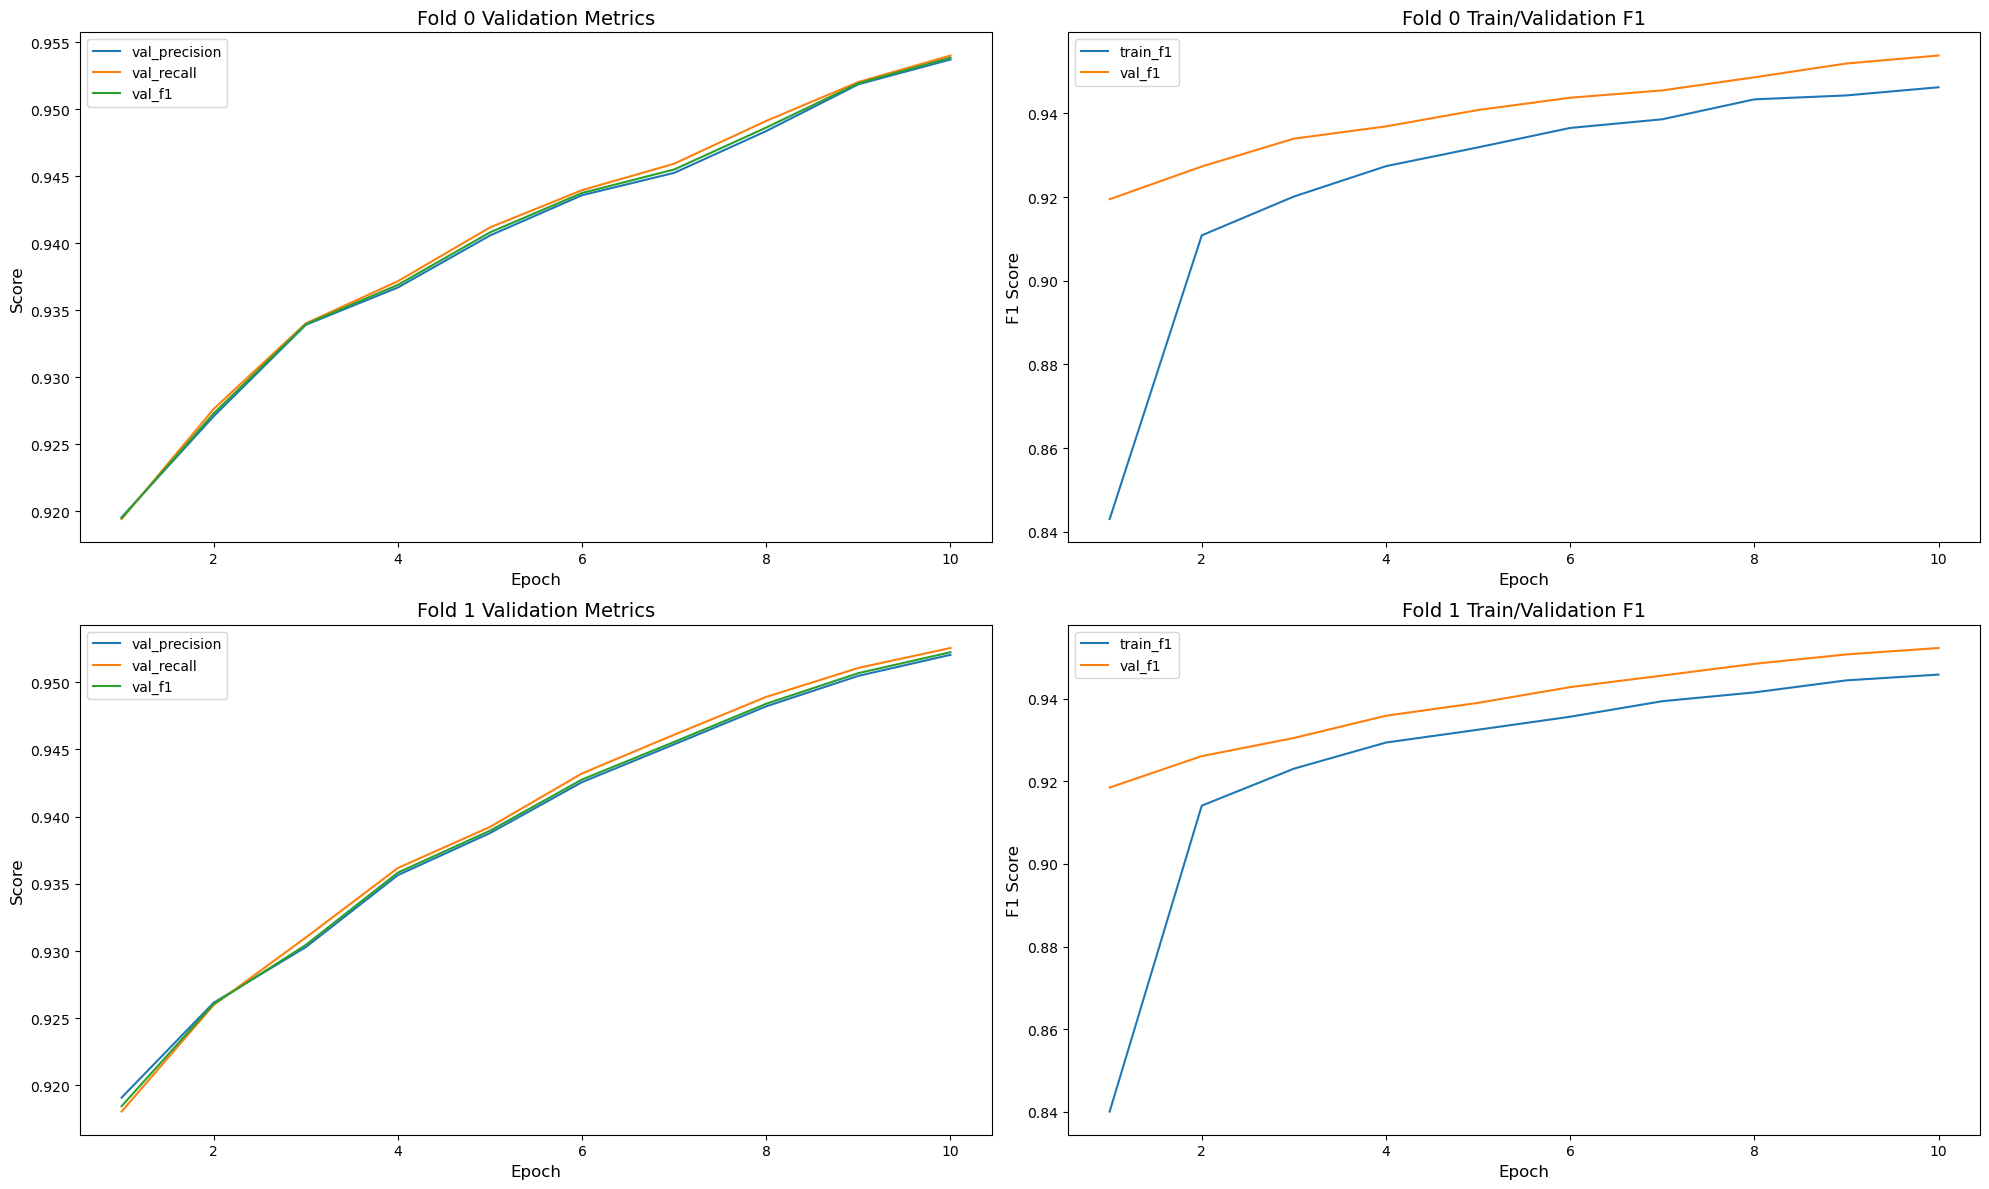

In [65]:
clf.plot_learning_curve()

In [68]:
print(test_data.shape)

(8980, 10)


In [71]:
data = {'id':[],
        'label':[]}
for i in range(0, 8980):
    data['id'].append(i)
    data['label'].append(0)

new_df = pd.DataFrame(data)
new_df.to_csv('sample_submission.csv', index=False)

In [72]:
y_pred = clf.predict(test_data)

model_submission = pd.read_csv("sample_submission.csv")
model_submission['label'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission.csv', index=False)
model_submission.describe()

,id,label
count,8980.000000,8980.000000
mean,4489.500000,0.485301
std,2592.447042,0.499812
min,0.000000,0.000000
25%,2244.750000,0.000000
50%,4489.500000,0.000000
75%,6734.250000,1.000000
max,8979.000000,1.000000


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_data['label'], model_submission['label'])
precision = precision_score(test_data['label'], model_submission['label'], average='macro', zero_division=0)
recall = recall_score(test_data['label'], model_submission['label'], average='macro', zero_division=0)
f1 = f1_score(test_data['label'], model_submission['label'], average='macro', zero_division=0)

print(f'Test Set Accuracy: {accuracy:.6f}')
print(f'Test Set Precision: {precision:.6f}')
print(f'Test Set Recall: {recall:.6f}')
print(f'Test Set F1 Score: {f1:.6f}')

Test Set Accuracy: 0.955234
Test Set Precision: 0.954953
Test Set Recall: 0.955518
Test Set F1 Score: 0.955170
